# Run a single optimization

This page contains a very simple tutorial on how to run a single optimizer.
Even though many folks have probably run a single local optimizer many times, this is meant to familiarize users with the basic API using the package.
Mystic has a plug-and-play API and the user can define many custom optimations, termination conditions, etc.
In this tutorial, we focus on how to apply some readily available out-of-the-box options instead of describing how to design new options.
After this basic introduction, we will then progress to multi-dimensional cost functions, multi-processing, and using a shared database.

The key concepts you should gain from this page:

 * How to define a cost function.
 * How to use an optimization algorithm to find the minimum of the cost function.
 * How to add a constraint.
 * What are the available optimization algorithms.
 * What are the available optimization termination conditions.
 
This is a very basic introduction to Mystic which is a library with a lot of functionality.
We will only touch a small part of the available options.
Feel free to see the [Mystic code documentation](https://mystic.readthedocs.io/en/latest/mystic.html) for more options.
There are links through these pages to classes and modules as they relate to the examples.

## Define a cost function

Similar to other packages like scipy, Mystic can optimize a Python function.
For example, below we define a cost function, called ``cost_func(params)``, which takes a list of parameters ``params``; ``params`` will be a ``list`` of ``float`` values.
This function specifies an inverted Gaussian using scipy.
In the section below, we will show how to find the minimum of this function.

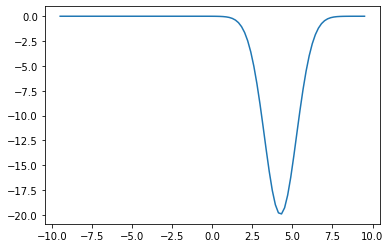

In [2]:
import matplotlib.pyplot as plt
import numpy
from scipy import stats

def cost_func(params):
    """ Executed for each set of drawn parameters in the optimization search.
    """

    # get the x value from Mystic
    # params is a list so we take the 0-th index of the list
    x = params

    # get value at inverted Gaussian function x
    # the Gaussian peak is at 4.25
    var = stats.multivariate_normal(mean=[4.25], cov=[[1]])
    stat = -50.0 * var.pdf([x])

    # whether to flip sign of function
    # a positive lets you search for minimum
    # a negative lets you search for maximum
    stat *= 1.0

    return stat

# plot the function between -9.5 and 9.5
x = numpy.linspace(-9.5, 9.5, 100)
plt.plot(x, [cost_func(i) for i in x])

# show the plot
plt.show()

## Run an opitimizer

We are going to use the ``PowellDirectionSolver`` which is a modified version of Powell's method on this cost function.
Below is an illustration of the local optimization algorithm which searches along search vectors, finds a minimum on the search vectors, and updates the search vectors.
 
 ![](img_powell_method.png)

First, we need to define a **solver** which implements a local optimization.
Below we choose to create a local optimization using the Powell method.
There are a two important options to set for the solver:

 1. **initial points**: Sets the initial position of the local optimizer using ``SetInitialPoints``.
 2. **strict ranges**: Sets the bounds for the parameters using ``SetStrictRages``.
 
The optimizer will also need a **termination condition**.
The termination conditions tells when the stop executing the local optmization.
This is set when the user calls ``Solve`` which executes the optimization.
 
 When you run this snippet, you should notice that the best parameter corresponds to 4.25 which is the minimum of our inverted Gaussian defined above in ``cost_func``.

In [17]:
from mystic import tools
from mystic.solvers import PowellDirectionalSolver
from mystic.ensemble import BuckshotSolver
from mystic.termination import VTR

# set random seed so we can reproduce results
tools.random_seed(0)

# create a solver
solver = PowellDirectionalSolver(dim=1)

# set the initial position to 1
solver.SetInitialPoints([1])

# set the range to search for the parameter between -9.5 and 9.5
solver.SetStrictRanges((-9.5,), (9.5,))

# find the minimum
# pass the termination condition
solver.Solve(cost_func, termination=VTR())

# print the best parameters
print(f"The best solution is {solver.bestSolution}")

The best solution is [4.25000001]


We can plot the minimum overlaid on the cost function.
In the plot below, the vertical line is our solution.

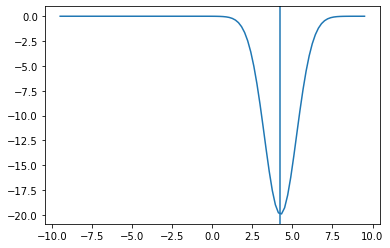

In [18]:
x = numpy.linspace(-9.5, 9.5, 100)
plt.plot(x, [cost_func(i) for i in x])
plt.axvline(solver.bestSolution[0])
plt.show()

## Add a constraint

We can add constraints as well.
For example, if we needed ``x`` to be an integer, we can tell Mystic to constraint our solutions to integers.
This is demonstrated below by the function ``as_int``.
Mystic has a number of common constraints and using the decorator ``@constraints.integers()`` as shown below, automatically has ``as_int`` return an integer.

The Mystic [constaints module](https://mystic.readthedocs.io/en/latest/mystic.html#module-mystic.constraints) includes the ``constraints.intergers`` decorator as well as others.

However, if the ``constraints.integers`` decorator didn't exist we could still write our own integer constraint.
For example, in the snippet below we add a commented-out block that is of a function that takes our new parameters ``x`` from the optimization algorithm and turns it into an ``int``.

In [19]:
from mystic import constraints

@constraints.integers()
def as_int(x):
    """ Our constraint function. We use a decorator from Mystic so
    that ``x`` above is already an integer. So we return ``x`` immediately.
    """
    return x

#def as_int(x):
#    """ What if constraints.integers didn't exist?
#    We could just turn ``x`` (a ``list`` of ``float``) into a
#    a ``list`` of ``int``. Like this function.
#    """
#    return list(map(int, x))
    
# set random seed so we can reproduce results
tools.random_seed(0)

# create a solver
solver = PowellDirectionalSolver(dim=1)

# set the initial position to 1
solver.SetInitialPoints([1])

# set the range to search for the parameter between -9.5 and 9.5
solver.SetStrictRanges((-9.5,), (9.5,))

# set the constraint
solver.SetConstraints(as_int)

# find the minimum
# pass the termination condition
solver.Solve(cost_func, termination=VTR())

# print the best parameters
print(f"The best solution is {solver.bestSolution}")

The best solution is [4.]


We see our best solution is now 4.
And if we look at our cost function again, it is indeed the lowest integer value.

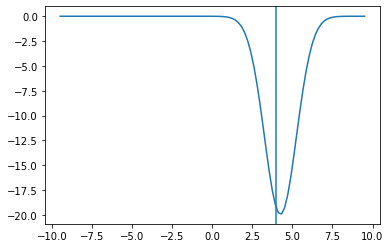

In [20]:
x = numpy.linspace(-9.5, 9.5, 100)
plt.plot(x, [cost_func(i) for i in x])
plt.axvline(solver.bestSolution[0])
plt.show()

## Available optimization algorithms

There are a couple global and local optimizers available in Mystic, some global optimization algorithms are:

 * ``DifferentialEvolutionSolver``: Differential Evolution algorithm. A type of evolutionary algorithm that has a population, creates a mutated population, and replaces weak with strong
 * ``DifferentialEvolutionSolver2``: Price & Storn's Differential Evolution algorithm.

Illustration of the differential evolution is shown below ([image source](https://pablormier.github.io/2017/09/05/a-tutorial-on-differential-evolution-with-python/)).

![](img_diffev.gif)

And the local optimization algorithms are:

 * ``PowellDirectionalSolver`` : Powell's (modified) Level Set algorithm.
 * ``NelderMeadSimplexSolver``: Nelder-Mead Simplex algorithm.
 
Illustration of Nelder-Mead is shown below ([image source](https://commons.wikimedia.org/wiki/File:Nelder-Mead_Rosenbrock.gif)).

![](img_nelder_mead.gif)

The documentation for these class is available in the [solvers module](https://mystic.readthedocs.io/en/latest/mystic.html#module-mystic.solvers).

Below we show how to use the global optimization algorithms to solve the same inverted Gaussian cost function.

In [22]:
from mystic.solvers import DifferentialEvolutionSolver
from mystic.solvers import DifferentialEvolutionSolver2

# set random seed so we can reproduce results
tools.random_seed(0)

# loop over different solvers
for cls in [DifferentialEvolutionSolver,
            DifferentialEvolutionSolver2]:
    
    # create a solver
    # note there is a second argument here
    # this is the population size set to 20
    solver = cls(dim=1, NP=20)

    # set the initial position to 1
    solver.SetInitialPoints([1])

    # set the range to search for the parameter between -9.5 and 9.5
    solver.SetStrictRanges((-9.5,), (9.5,))

    # find the minimum
    # pass the termination condition
    solver.Solve(cost_func, termination=VTR())
    
    # print the best solution
    print(f"The {cls.__name__} best solution is {solver.bestSolution[0]}")

The DifferentialEvolutionSolver best solution is 4.249999998671815
The DifferentialEvolutionSolver2 best solution is 4.250000003848005


A lot of the classes in Mystic have an analogous function-interface that can be used to call the optimization in a single line.
Below, we show an example using the ``diffev2`` which is analogous to ``DifferentialEvolutionSolver2`` above. Other functions in the [solvers modules](https://mystic.readthedocs.io/en/latest/mystic.html#module-mystic.solvers) includes ``diffev``, ``fmin`` (Nelder-Mead), and ``fmin_powell`` (Powell).

In [23]:
from mystic.solvers import diffev2

# set random seed so we can reproduce results
tools.random_seed(0)

# find minimum/maximum of surrogate
results = diffev2(cost_func, x0=[(-9.5, 9.5)], npop=20,
                  bounds=[(-9.5, 9.5)], full_output=True)

# print the best solution
print(f"The best solution is {results[0]}")

Optimization terminated successfully.
         Current function value: -19.947114
         Iterations: 42
         Function evaluations: 860
The best solution is [4.25]


## Available termination conditions

Above, we had shown that you use the ``VTR`` termination condition to tell the optimization algorithm when to stop.
There are quite a few termination conditions available in Mystic. Here, we list some, but not all, termination conditions:

 * ``VTR``: Cost function from last iteration is less than some tolerance to target value. 
 * ``NormalizedChangeOverGeneration``: Normalized change in cost is less than a tolerance over number of generations. See Mystic documentation for how normalized change is defined.
 
For more you can check the documentation in Mystic for the [termination module](https://mystic.readthedocs.io/en/latest/mystic.html#module-mystic.termination).

In addition to setting a termination condition, you can set the maximum number of optimization iterations (also called *generations*) or maximum number of calls to the cost function with:
```
solver.SetEvaluationLimits(generations=2, evaluations=10)
```
In the example above, we limit to 2 generations or no more than 10 calls to the cost function.

Below we use the ``NormalizedChangeOverGeneration`` and ``SetEvaluationLimits``.
Note, we are going to termination the optimization early, so we expect our result to be less accurate than the prior example.
However, removing the ``SetEvaluationLimits`` or increasing its arguments should get closer to the expected result.
If we have an expensive cost function, this is one way to terminate after so many calls.
So if you know how long an optimization takes on the processors you have available, you can return the best answer in a certain amount of time-useful in real-time, approximate results for expensive cost functions.

In [25]:
from mystic.termination import NormalizedChangeOverGeneration

# set random seed so we can reproduce results
tools.random_seed(0)

# create a solver
solver = PowellDirectionalSolver(dim=1)

# set the initial position to 1
solver.SetInitialPoints([1])

# set the range to search for the parameter between -9.5 and 9.5
solver.SetStrictRanges((-9.5,), (9.5,))

# terminate after a single optimization iteration or single call to cost function
solver.SetEvaluationLimits(generations=2, evaluations=10)

# find the minimum
# pass the termination condition
solver.Solve(cost_func, termination=NormalizedChangeOverGeneration())

# print the best parameters
print(f"The best solution is {solver.bestSolution}")


The best solution is [4.26579748]


Recall, to optimize this cost function we are specifying: a **solver**, **initial points**, **strict ranges**, and a **termination condition**.
We also have the option to set a **constraint**.

Now that you have a understanding of how to use a single optimizer, on the next page we will move on to multi-dimensional cost functions and running multiple optimizers in a search.